In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [10]:
# get data
import yfinance as yf

# 1. get train data
ticker = '0066.HK'
start_date = '2010-01-01'
end_date = '2020-06-30'
df = yf.download(ticker, start=start_date, end=end_date)

# get test data
test_start_date = '2021-01-01'
test_end_date = '2021-04-30'
df_test = yf.download(ticker, start=test_start_date, end=test_end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
# 2. data preprocessing
# use the 'Close' price
df = df[['Close']].dropna()
df_test = df_test[['Close']].dropna()

# min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df_test['Close'] = scaler.transform(df_test['Close'].values.reshape(-1,1))

# create dataset
def create_dataset(data, look_back=5):
    X, Y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

# train set
X_train, y_train = create_dataset(df.values, look_back)
# test set
X_test, y_test = create_dataset(df_test.values, look_back)

# reshape
X_train = X_train
X_test = X_test

In [12]:
# 3. model training

# (a) random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# (b) decision tree regression model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# (c) linear regression model
ln_model = linear_model.LinearRegression()
ln_model.fit(X_train, y_train)


LinearRegression()

In [13]:
# (d) tensorflow model
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50


2024-11-23 22:58:09.971042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-23 22:58:09.971583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-23 22:58:09.972654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

41/41 [==============================] - 2s 11ms/step - loss: 0.0266
Epoch 2/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 3/50
41/41 [==============================] - 0s 11ms/step - loss: 7.8352e-04
Epoch 4/50
41/41 [==============================] - 0s 11ms/step - loss: 7.4730e-04
Epoch 5/50
41/41 [==============================] - 0s 11ms/step - loss: 7.7252e-04
Epoch 6/50
41/41 [==============================] - 0s 11ms/step - loss: 7.2149e-04
Epoch 7/50
41/41 [==============================] - 0s 11ms/step - loss: 7.0613e-04
Epoch 8/50
41/41 [==============================] - 0s 11ms/step - loss: 6.9417e-04
Epoch 9/50
41/41 [==============================] - 0s 11ms/step - loss: 7.0470e-04
Epoch 10/50
41/41 [==============================] - 0s 11ms/step - loss: 6.7113e-04
Epoch 11/50
41/41 [==============================] - 0s 11ms/step - loss: 6.3107e-04
Epoch 12/50
41/41 [==============================] - 0s 11ms/step - loss: 6.2131e-04
Epoch 13

In [16]:
# 4. model evaluation

# predict
rf_pred = rf_model.predict(X_test)
dt_pred = dt_model.predict(X_test)
ln_pred = ln_model.predict(X_test)
lstm_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# inverse transform
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
rf_pred_actual = scaler.inverse_transform(rf_pred.reshape(-1, 1))
dt_pred_actual = scaler.inverse_transform(dt_pred.reshape(-1,1))
ln_pred_actual = scaler.inverse_transform(ln_pred.reshape(-1, 1))
lstm_pred_actual = scaler.inverse_transform(lstm_pred.reshape(-1, 1))

# calculate MSE
rf_mse = mean_squared_error(y_test_actual, rf_pred_actual)
dt_mse = mean_squared_error(y_test_actual, dt_pred_actual)
ln_mse = mean_squared_error(y_test_actual, ln_pred_actual)
lstm_mse = mean_squared_error(y_test_actual, lstm_pred_actual)

print('Random Forest MSE: ', rf_mse)
print('Decision Tree MSE: ', dt_mse)
print('Linear Regression MSE: ', ln_mse)
print('LSTM MSE: ', lstm_mse)

2/2 [==============================] - 0s 4ms/step
Random Forest MSE:  0.36397587214144445
Decision Tree MSE:  1.0953819624069878
Linear Regression MSE:  0.2864988215648874
LSTM MSE:  0.526296769557136


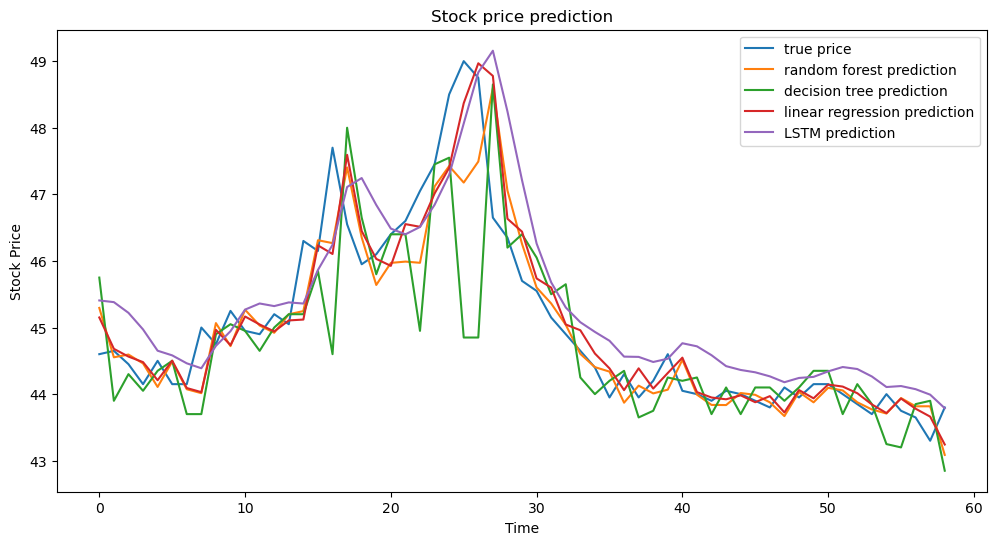

In [15]:
# 5. plot the prediction result

# plot
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='true price')
plt.plot(rf_pred_actual, label='random forest prediction')
plt.plot(dt_pred_actual, label='decision tree prediction')
plt.plot(ln_pred_actual, label='linear regression prediction')
plt.plot(lstm_pred_actual, label='LSTM prediction')
plt.legend()
plt.title('Stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()